In [7]:
# ============================
# IMPORTAR LIBRERÍAS NECESARIAS
# ============================

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [8]:
# Rutas del dataset
train_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/train/'
validation_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/'
test_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images/test/'

# Parámetros del modelo
IMG_SIZE = (224, 224)  # Tamaño de imagen para VGG16
BATCH_SIZE = 64
N_CLASSES = 15         # Tu notebook original encontró 15 carpetas (clases)
EPOCHS = 5            # Número de épocas para entrenar


In [9]:
# Cargar datos de entrenamiento
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='int',       # Las etiquetas serán números (0, 1, 2...)
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Cargar datos de validación
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Guardar los nombres de las clases (ej. 'Bean', 'Broccoli', 'Carrot'...)
class_names = train_dataset.class_names
print(f"Clases encontradas: {class_names}")

# Optimizar la carga de datos (buena práctica)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Clases encontradas: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [10]:
# 1. Cargar el modelo base VGG16 (corrigiendo weights=None)
# Usamos 'imagenet' para que sepa de imágenes
# include_top=False para quitar la última capa y poner la nuestra
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(224, 224, 3))

# 2. Congelar el modelo base (no queremos re-entrenarlo)
base_model.trainable = False

# 3. Añadir nuestra "cabeza" de clasificación
inputs = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)  # "Achata" las características
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) # Regularización para evitar sobreajuste
outputs = Dense(N_CLASSES, activation='softmax')(x) # Capa final para 15 clases

# Crear el modelo final
model = Model(inputs=inputs, outputs=outputs)

# Ver la arquitectura
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,782,287 (56.39 MB)

 Trainable params: 67,599 (264.06 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
print("Iniciando entrenamiento...")

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

print("Entrenamiento finalizado.")

Iniciando entrenamiento...
Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 129s 538ms/step - accuracy: 0.1725 - loss: 9.0439 - val_accuracy: 0.7673 - val_loss: 0.7844
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 98s 418ms/step - accuracy: 0.5656 - loss: 1.6623 - val_accuracy: 0.8883 - val_loss: 0.4186
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 98s 416ms/step - accuracy: 0.7136 - loss: 0.9857 - val_accuracy: 0.9327 - val_loss: 0.2531
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 97s 415ms/step - accuracy: 0.7885 - loss: 0.6997 - val_accuracy: 0.9530 - val_loss: 0.1692
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 98s 415ms/step - accuracy: 0.8423 - loss: 0.5223 - val_accuracy: 0.9680 - val_loss: 0.1256
Entrenamiento finalizado.


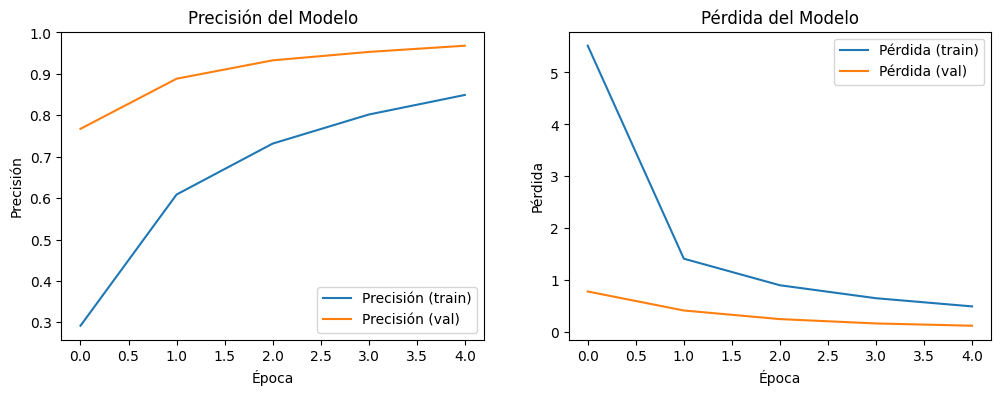

In [13]:
plt.figure(figsize=(12, 4))

# Gráfica de Precisión (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión (train)')
plt.plot(history.history['val_accuracy'], label='Precisión (val)')
plt.title('Precisión del Modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de Pérdida (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida (train)')
plt.plot(history.history['val_loss'], label='Pérdida (val)')
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


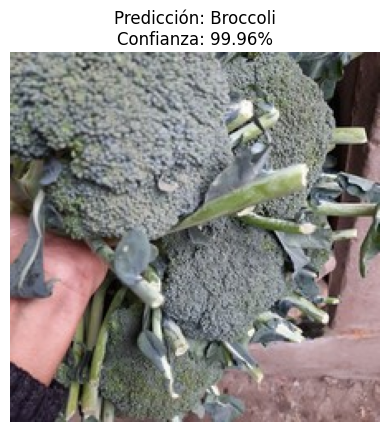

In [14]:
def identify_vegetable(img_path, model, class_names):
    """
    Carga, preprocesa y predice la clase de una imagen de vegetal.
    """
    # 1. Cargar la imagen
    img = image.load_img(img_path, target_size=IMG_SIZE)
    
    # 2. Convertir a array y preprocesar (igual que en el notebook original)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array) # Preprocesado VGG16
    
    # 3. Hacer la predicción
    predictions = model.predict(img_array)
    
    # 4. Interpretar resultados
    score = np.max(predictions[0])
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    
    # 5. Mostrar resultados
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicción: {predicted_class_name}\nConfianza: {score:.2%}")
    plt.show()
    
    return predicted_class_name, score

# --- Ejemplo de uso ---
# (Asegúrate de que la ruta exista en tu set de 'test')
try:
    # Tomemos una imagen de prueba (ej. la primera de 'Broccoli')
    test_image_path = os.path.join(test_dir, 'Broccoli', '1001.jpg')
    
    if os.path.exists(test_image_path):
        identify_vegetable(test_image_path, model, class_names)
    else:
        print(f"Ruta de prueba no encontrada: {test_image_path}")
        # Intenta con otra (ej. 'Carrot')
        test_image_path = os.path.join(test_dir, 'Carrot', '1001.jpg')
        if os.path.exists(test_image_path):
            identify_vegetable(test_image_path, model, class_names)
        else:
            print("Tampoco se encontró la imagen de zanahoria. Verifica tus rutas de 'test'.")

except Exception as e:
    print(f"Error al probar la predicción: {e}")
    print("Asegúrate de que las carpetas 'test' (ej. 'Broccoli', 'Carrot') existen.")